# INFORMATION

In [3]:
# NETWORK TYPE       : SIAMESE NETWORK

# Dataset            : ...
# Iteration          : 760
# Training set size  : 75754
# Test set size      : 16368
# Model Parameters   : 1,240,588


# Preprocessing Time : About 5 mins
# Training Time      : About 30 mins
# GPU Used           : NVIDIA RTX 2080 Ti

# PRELIMINARIES

In [8]:
'''PATHS'''

# Path to directroy contain notebook and dataset. 
working_directory = "/content/drive/My Drive/Signature_Verification"

working_directory = "."


# Path of training set.
training_set_path = "./sign_data/train"

# Path of test set.
test_set_path = "./sign_data/test"

# Extention applied to folders containg real files.
real_extention = ""

# Extention applied to folders containg fake files.
fake_extention = "_forg"


In [9]:
'''HYPER-PARAMETERS'''

# Hyperparameters

global_image_height = 400
global_image_width = 700

triplet_loss_margin = 1
learning_rate = 0.001
batch_size = 100


In [10]:
'''IMPORTS'''

import os
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable


In [14]:
'''MOUNTING GOOGLE DRIVE'''

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Unzip the Dataset
# !unzip dataset.zip

# Explore Directory
os.chdir(working_directory)
!ls

dataset.zip  import.sh	notebook.ipynb	onstart.log  onstart.sh  sign_data




# AUXILLARY FUNCTIONS

In [15]:
def get_single_perm(is_train, location):
    
    """
    Retuns a list containing all [anchor, positive, negative] path permutations 
    in a given folder.
    
    Note : `location` must be an integer denoting the folder number.
    """
   
    index = []
        
    if(is_train):
        root_path = training_set_path
    else:
        root_path = test_set_path
    
    originals = os.listdir(os.path.join(root_path, location + real_extention))
    forgeries = os.listdir(os.path.join(root_path, location + fake_extention))

    originals.sort()
    forgeries.sort()
    
    for i in range(len(originals)):
        for j in range(i+1,len(originals)):
            for k in range(len(forgeries)):
                
                path_anchor = os.path.join(root_path, location + real_extention, originals[i])
                path_real = os.path.join(root_path, location + real_extention, originals[j])
                path_fake = os.path.join(root_path, location + fake_extention, forgeries[k])
                
                index.append([path_anchor, path_real, path_fake])
  
    return index

In [16]:
def build_file_index(is_train=True):
    
    """
    Returns a master index file that contains all the 
    [anchor, real, fake] path permuataions across the whole dataset.    
    """
        
    if(is_train):
        directory = training_set_path
    else:
        directory = test_set_path
    
    folder_list = os.listdir(directory)
    folder_list.sort()
                           
    master_index = []
                           
    for i in range(len(folder_list)):
        if(i%2==0):
            master_index = master_index + get_single_perm(is_train, folder_list[i])    
    
    return master_index

In [17]:
def get_image_from_path(image_path):
    
    """
    Returns a numpy array containing the image at the provided `path`.
    """
    
    image = cv2.imread(str(image_path))
    image = np.array(image)
    return image

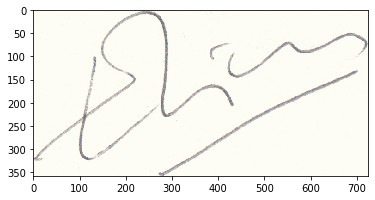

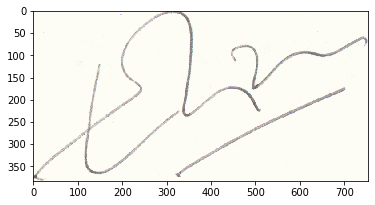

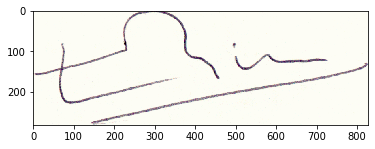

In [18]:
def print_img(image):
    
    """
    Plots a simgle image. 
    Accepts raw data, NOT path.
    """    
    
    imgplot = plt.imshow(image)
    plt.show()

    
print_img(get_image_from_path('./sign_data/train/001/001_01.PNG'))
print_img(get_image_from_path('./sign_data/train/001/001_02.PNG'))
print_img(get_image_from_path('./sign_data/train/001_forg/0201001_02.png'))

# DATA WRANGLING

In [19]:
'''DATA PREPROCESSING'''


def resize_images(new_dim1=global_image_height, new_dim2=global_image_width, is_train=True):

    '''
    Transforms all images in the dataset into correct sizes.
    Then rewrites them at their original path.
    '''
    
    if(is_train):
        directory = training_set_path
    else:
        directory = test_set_path

    # Get all Folders    
    folder_list = os.listdir(directory)
    folder_list.sort()            
        
    for folder in folder_list:
        
        # Get all Images in a folder
        image_list = os.listdir(os.path.join(directory,folder))
        image_list.sort()    
                                  
        for image_name in image_list:
            
            # Get image path
            image_path = str(os.path.join(directory,folder,image_name))
            
            # Get image
            image = get_image_from_path(image_path)
            
            # Resize image
            resized_image = cv2.resize(image, (new_dim2, new_dim1))
            
            # Overwrite the Image
            cv2.imwrite(image_path, resized_image)            

# Applting the tranformations over the training and test set.
resize_images(is_train = True)
resize_images(is_train = False)

In [20]:
'''MODIFIED IMAGES'''

# print_img(get_image_from_path('./sign_data/train/001/001_01.PNG'))
# print_img(get_image_from_path('./sign_data/train/001/001_02.PNG'))
# print_img(get_image_from_path('./sign_data/train/001_forg/0201001_02.png'))

'MODIFIED IMAGES'

# CREATING THE DATASET CLASS

In [21]:
# List of all the path permutations in the train file
train_master_index = build_file_index(is_train = True)

# List of all the path permutations in the test file
test_master_index = build_file_index(is_train = False)

print("Training set size : ", len(train_master_index))
print("Test set size : ", len(test_master_index))

Training set size :  75754
Test set size :  16368


In [22]:
'''CREATING DATASET CLASS'''

def transform_image(path):
    
    """
    Rotate the image so that the model can process it.
    """
    
    image = get_image_from_path(path)
    image = np.rollaxis(image, 2, 0)
    return image


class signature_dataset(Dataset):
        
    def __init__(self, is_train=True, transform=None):  
        
        self.is_train = is_train
        self.transform = transform
    
    def __getitem__(self, index):
        
        if(self.is_train):
            master_index = train_master_index
        else:
            master_index = test_master_index
        
        # Get paths
        anchor_path = master_index[index][0]
        real_path = master_index[index][1]
        fake_path = master_index[index][2]
            
        # Transform images
        anchor = transform_image(anchor_path)
        real = transform_image(real_path)
        fake = transform_image(fake_path)
        
        
        if self.transform is not None:
            anchor = self.transform(anchor)
            real = self.transform(real)
            fake = self.transform(fake)
        
        return anchor, real, fake
    
    
    def __len__(self):
        
        if(self.is_train):
            master_index = train_master_index
        else:
            master_index = test_master_index
        
        return len(master_index)
        

In [23]:
'''LOADING DATASET'''

train_dataset = signature_dataset(is_train = True)
test_dataset = signature_dataset(is_train = False)

In [24]:
'''MAKING DATASET ITERABLE'''

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# CREATING THE MODEL

In [25]:
'''CREATEING MODEL CLASS'''

class SiameseModel(nn.Module):
    
    def __init__(self):
        
        super(SiameseModel, self).__init__()
        
        # Convolution 1 [03,400,700 -> 16,77,137]
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=20, stride=5, padding=0)
        self.relu1 = nn.ReLU() 
        
        # Max pool 1 [16,77,137 -> 16,38,68]
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution 2 [16,38,68 -> 32,36,66]
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2 [32,36,66 -> 32,18,33]
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolution 3 [32,18,33 -> 64,16,31]
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        
        # Max pool 3 [64,16,31 -> 64,8,15]
        self.maxpool3 = nn.MaxPool2d(kernel_size=[2,3], stride=2)
        
        # Fully connected (readout) [64*8*15 -> 156]
        self.fc1 = nn.Linear(64 * 8 * 15, 156) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)
        
        # Max pool 3 
        out = self.maxpool3(out)
        
        # Resize [100,64,8,15 -> 100,64*8*15]
        out = out.view(out.size(0), -1)    
        
        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [27]:
'''INSTANTIATING MODEL CLASS'''

model = SiameseModel()

if torch.cuda.is_available():
    model.cuda()
    
# summary(model, input_size=(3, global_image_height, global_image_width))

In [28]:
'''INSTANTIATING LOSS CLASS'''

triplet_loss = nn.TripletMarginLoss(margin=triplet_loss_margin)

In [29]:
'''INSTANTIATING OPTIMIZER CLASS'''

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# TRAINING THE MODEL

In [30]:
'''INITIALIZING SOME VARIABLES'''

iterr = 0

# Initializing inspection lists
iter_list = []                           # Saves Iterations at which the model has been evaluated
train_loss_list = []                     # Saves Train Loss
train_acc_list = []                      # Saves Train Accuracy
test_loss_list = []                      # Saves Test Loss
test_acc_list = []                       # Saves Test Accuracy

In [31]:
'''SETTING CUSTOM PARAMETERS'''

# Number of iteration to train the model
n_iters = 760

# Size at which model is evaluated for later inspection
inspect_size = 15                                                 

num_epochs = int(n_iters / (len(train_dataset) / batch_size))

print("Number of Iterations     :", n_iters)
print("Number of Epochs         :", num_epochs)
print("Number of Sample-Points  :", int(n_iters/inspect_size))

Number of Iterations     : 760
Number of Epochs         : 1
Number of Sample-Points  : 50


In [32]:
'''HELPER FUNCTIONS'''


def get_encodings(matrix):

    '''
    Accepts a Tensor and returns its encoding.
    '''
    
    if torch.cuda.is_available():
        matrix = Variable(matrix.cuda())    
    else:
        matrix = Variable(matrix)
    
    matrix = matrix.float()
    matrix_enc = model(matrix)
    
    return matrix_enc



def return_diff(anchors_enc, positives_enc, negatives_enc):
 
    '''
    Accepts the encodings of three tensors.
    
    Returns d(E1,E2) and d(E1,E3) where d(A,B) is the 
    Frobenius norm of the vector A-B.
    
    Returns the result as a pair of numpy arrays.
    '''

    assert(anchors_enc.shape == positives_enc.shape)
    assert(anchors_enc.shape == negatives_enc.shape)
    
    num = anchors_enc.shape[0]
    pos_diff_vec = []
    neg_diff_vec = []
    
    anchors_enc = anchors_enc.cpu().detach().numpy()
    positives_enc = positives_enc.cpu().detach().numpy()
    negatives_enc = negatives_enc.cpu().detach().numpy()
    
    for i in range(num):
        pos_diff = np.linalg.norm(anchors_enc[i] - positives_enc[i])
        neg_diff = np.linalg.norm(anchors_enc[i] - negatives_enc[i])
        
        pos_diff_vec.append(pos_diff)
        neg_diff_vec.append(neg_diff)
   
    return np.array(pos_diff_vec), np.array(neg_diff_vec)    

In [33]:
'''TRAINING THE MODEL'''

import time
time_begin = time.asctime()   # Time when training started

init_iters = iterr

for epoch in range(num_epochs):
    for i, (anchors, positives, negatives) in enumerate(train_loader):
        
#         if(i == 5): break
        
        
        # Get encodings by forward propogation
        anchors_enc = get_encodings(anchors)
        positives_enc = get_encodings(positives) 
        negatives_enc = get_encodings(negatives)
           
        # Clearing the previous gradients
        optimizer.zero_grad()                                        

         # Calculating the Train loss
        loss = triplet_loss(anchors_enc, positives_enc, negatives_enc)
        
        # Backward propogation
        loss.backward()
       
        # Optimizing the parameters
        optimizer.step()                                            
        
        iterr += 1
        
        print("Iter {:.0f} Done.\t Loss : {:.5f}".format(iterr - init_iters, loss.item()))
        
        
        # -----------------------------------------------------------------------------------------------------------------------------------------------------------
        ### Inspecting the performance of the model ###
        
        if (iterr == 0 or iterr % inspect_size == 0):
        
            iter_list.append(iterr)
            print("Iteration : {:.0f}/{:.0f} [{:2.0f}%] ".format(iterr - init_iters, n_iters, 100*(iterr - init_iters)/n_iters))
            print('---------------------------')
            
        # -----------------------------------------------------------------------------------------------------------------------------------------------------------
        ### Calculating train accuracy and loss ###                                          

            # NOTE : Using encoding obtained in current training iteration.
        
            # Append train loss
            train_loss_list.append(loss.item())
            
            # Use encoding to obtain vector difference
            pos_diff, neg_diff = return_diff(anchors_enc, positives_enc, negatives_enc)
            
            # Append train accuracy
            num_sample = anchors.shape[0]
            tot_correct = np.sum(pos_diff < neg_diff)
            train_acc = tot_correct/num_sample * 100
            train_acc_list.append(train_acc)
            
            print('[Train]\t Loss: {:.5f} | Acc: {:2.0f}%'.format(loss.item(), train_acc)) 
        
        # -----------------------------------------------------------------------------------------------------------------------------------------------------------
        ### Calculating test accuracy and loss ###
            
            # Use 100 samples for inspection from test set
            anchors, positives, negatives = next(iter(test_loader))

            # Get encodings by forward propogation
            anchors_enc = get_encodings(anchors)
            positives_enc = get_encodings(positives) 
            negatives_enc = get_encodings(negatives)

            # Append test loss
            loss = triplet_loss(anchors_enc, positives_enc, negatives_enc)        
            test_loss_list.append(loss.item())                  
                  
            # Use encoding to obtain vector difference
            pos_diff, neg_diff = return_diff(anchors_enc, positives_enc, negatives_enc)
            
            # Append test accuracy 
            num_sample = anchors.shape[0]
            tot_correct = np.sum(pos_diff < neg_diff)
            test_acc = tot_correct/num_sample * 100
            test_acc_list.append(test_acc)
            
            print('[Test ]\t Loss: {:.5f} | Acc: {:2.0f}%'.format(loss.item(), test_acc))        
        
        # -----------------------------------------------------------------------------------------------------------------------------------------------------------
            print('=========================================================')
            
            
print("\nTraining Done.")
time_end = time.asctime()    # Time when training ended

Iter 1 Done.	 Loss : 0.14557
Iter 2 Done.	 Loss : 0.21168
Iter 3 Done.	 Loss : 0.11992
Iter 4 Done.	 Loss : 0.04521
Iter 5 Done.	 Loss : 0.10324
Iter 6 Done.	 Loss : 0.11340
Iter 7 Done.	 Loss : 0.10455
Iter 8 Done.	 Loss : 0.15453
Iter 9 Done.	 Loss : 0.08825
Iter 10 Done.	 Loss : 0.08118
Iter 11 Done.	 Loss : 0.11669
Iter 12 Done.	 Loss : 0.21851
Iter 13 Done.	 Loss : 0.16140
Iter 14 Done.	 Loss : 0.17823
Iter 15 Done.	 Loss : 0.28434
Iteration : 15/760 [ 2%] 
---------------------------
[Train]	 Loss: 0.28434 | Acc: 90%
[Test ]	 Loss: 0.07691 | Acc: 97%
Iter 16 Done.	 Loss : 0.06771
Iter 17 Done.	 Loss : 0.09421
Iter 18 Done.	 Loss : 0.14141
Iter 19 Done.	 Loss : 0.05604
Iter 20 Done.	 Loss : 0.12675
Iter 21 Done.	 Loss : 0.08704
Iter 22 Done.	 Loss : 0.12934
Iter 23 Done.	 Loss : 0.10722
Iter 24 Done.	 Loss : 0.12542
Iter 25 Done.	 Loss : 0.04365
Iter 26 Done.	 Loss : 0.12651
Iter 27 Done.	 Loss : 0.12307
Iter 28 Done.	 Loss : 0.08618
Iter 29 Done.	 Loss : 0.05183
Iter 30 Done.	 Lo

[Test ]	 Loss: 0.01223 | Acc: 99%
Iter 196 Done.	 Loss : 0.00000
Iter 197 Done.	 Loss : 0.03378
Iter 198 Done.	 Loss : 0.00535
Iter 199 Done.	 Loss : 0.00378
Iter 200 Done.	 Loss : 0.01261
Iter 201 Done.	 Loss : 0.01187
Iter 202 Done.	 Loss : 0.02785
Iter 203 Done.	 Loss : 0.04122
Iter 204 Done.	 Loss : 0.00399
Iter 205 Done.	 Loss : 0.00705
Iter 206 Done.	 Loss : 0.01873
Iter 207 Done.	 Loss : 0.00104
Iter 208 Done.	 Loss : 0.03819
Iter 209 Done.	 Loss : 0.00609
Iter 210 Done.	 Loss : 0.00831
Iteration : 210/760 [28%] 
---------------------------
[Train]	 Loss: 0.00831 | Acc: 100%
[Test ]	 Loss: 0.00521 | Acc: 100%
Iter 211 Done.	 Loss : 0.01715
Iter 212 Done.	 Loss : 0.00000
Iter 213 Done.	 Loss : 0.02605
Iter 214 Done.	 Loss : 0.01251
Iter 215 Done.	 Loss : 0.00158
Iter 216 Done.	 Loss : 0.01230
Iter 217 Done.	 Loss : 0.00266
Iter 218 Done.	 Loss : 0.01261
Iter 219 Done.	 Loss : 0.00000
Iter 220 Done.	 Loss : 0.02017
Iter 221 Done.	 Loss : 0.00841
Iter 222 Done.	 Loss : 0.00171
Iter

Iter 387 Done.	 Loss : 0.00000
Iter 388 Done.	 Loss : 0.00452
Iter 389 Done.	 Loss : 0.01316
Iter 390 Done.	 Loss : 0.00000
Iteration : 390/760 [51%] 
---------------------------
[Train]	 Loss: 0.00000 | Acc: 100%
[Test ]	 Loss: 0.00214 | Acc: 100%
Iter 391 Done.	 Loss : 0.00000
Iter 392 Done.	 Loss : 0.01824
Iter 393 Done.	 Loss : 0.00217
Iter 394 Done.	 Loss : 0.00557
Iter 395 Done.	 Loss : 0.00000
Iter 396 Done.	 Loss : 0.00000
Iter 397 Done.	 Loss : 0.00000
Iter 398 Done.	 Loss : 0.00245
Iter 399 Done.	 Loss : 0.01419
Iter 400 Done.	 Loss : 0.00000
Iter 401 Done.	 Loss : 0.01299
Iter 402 Done.	 Loss : 0.00752
Iter 403 Done.	 Loss : 0.00000
Iter 404 Done.	 Loss : 0.03586
Iter 405 Done.	 Loss : 0.00000
Iteration : 405/760 [53%] 
---------------------------
[Train]	 Loss: 0.00000 | Acc: 100%
[Test ]	 Loss: 0.01417 | Acc: 99%
Iter 406 Done.	 Loss : 0.00000
Iter 407 Done.	 Loss : 0.01228
Iter 408 Done.	 Loss : 0.00919
Iter 409 Done.	 Loss : 0.00000
Iter 410 Done.	 Loss : 0.00000
Iter 41

Iter 575 Done.	 Loss : 0.00300
Iter 576 Done.	 Loss : 0.00229
Iter 577 Done.	 Loss : 0.00000
Iter 578 Done.	 Loss : 0.00000
Iter 579 Done.	 Loss : 0.00000
Iter 580 Done.	 Loss : 0.01718
Iter 581 Done.	 Loss : 0.00261
Iter 582 Done.	 Loss : 0.00423
Iter 583 Done.	 Loss : 0.00000
Iter 584 Done.	 Loss : 0.00280
Iter 585 Done.	 Loss : 0.00000
Iteration : 585/760 [77%] 
---------------------------
[Train]	 Loss: 0.00000 | Acc: 100%
[Test ]	 Loss: 0.00000 | Acc: 100%
Iter 586 Done.	 Loss : 0.00000
Iter 587 Done.	 Loss : 0.00423
Iter 588 Done.	 Loss : 0.00607
Iter 589 Done.	 Loss : 0.00196
Iter 590 Done.	 Loss : 0.00000
Iter 591 Done.	 Loss : 0.00000
Iter 592 Done.	 Loss : 0.00000
Iter 593 Done.	 Loss : 0.00000
Iter 594 Done.	 Loss : 0.00000
Iter 595 Done.	 Loss : 0.00109
Iter 596 Done.	 Loss : 0.00078
Iter 597 Done.	 Loss : 0.00000
Iter 598 Done.	 Loss : 0.00247
Iter 599 Done.	 Loss : 0.00439
Iter 600 Done.	 Loss : 0.00000
Iteration : 600/760 [79%] 
---------------------------
[Train]	 Loss:

# BACKUPING UP

In [34]:
'''SAVING THE MODEL'''

torch.save(model.state_dict(), 'state_dict_margin=1_2.pt')

In [57]:
'''LOADING THE MODEL'''

# model.load_state_dict(torch.load('state_dict_margin=10_1.pt'))
# model.eval()

SiameseModel(
  (cnn1): Conv2d(3, 16, kernel_size=(20, 20), stride=(5, 5))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=[2, 3], stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7680, out_features=156, bias=True)
)

# ANALYSIS

In [35]:
'''POST TRAINING RESULTS'''

# Formatting the date-time data
from datetime import datetime
FMT = '%H:%M:%S'
td = (datetime.strptime(time_end[11:19], FMT) - datetime.strptime(time_begin[11:19], FMT)).seconds
hr = (td//3600)
min = (td - 3600*hr)//60
sec = (td - 3600*hr - 60*min)

print("Total Iterations     : {:.0f}".format(iterr))
print("Total Epochs         : {:.0f}".format(iterr*100/60000))
print("Total Sample-Points  : {:.0f}".format(iterr/inspect_size))
print("-------------------------------")
print("Loss - Train     : {:.2f}".format(np.mean(train_loss_list[-10:])))
print("Loss - Test      : {:.2f}".format(np.mean(test_loss_list[-10:])))
print("Acc - Train     : {:.2f}".format(np.mean(train_acc_list[-10:])))
print("Acc - Test      : {:.2f}".format(np.mean(test_acc_list[-10:])))
print("-------------------------------")
print("Start Time        : {}".format(time_begin[11:19]))
print("End Time          : {}".format(time_end[11:19]))
print("Total Train-time  : {:2.0f}:{:2.0f}:{:2.0f}".format(hr,min,sec))

Total Iterations     : 758
Total Epochs         : 1
Total Sample-Points  : 51
-------------------------------
Loss - Train     : 0.00
Loss - Test      : 0.00
Acc - Train     : 100.00
Acc - Test      : 99.90
-------------------------------
Start Time        : 06:49:27
End Time          : 07:25:57
Total Train-time  :  0:36:30


In [36]:
'''GENERATING AVERAGE INSPECTION LISTS'''

# Defining roll function
def make_roll(input_list, roll_size=5):
    output_list = []
    
    for i in range(len(input_list)):
        if i==0:
            output_list.append(input_list[0])
        elif i<roll_size:
            output_list.append(np.mean(input_list[:i+1]))
        else:
            output_list.append(np.mean(input_list[i-roll_size:i]))
    return output_list

# Generating roll lists
train_roll_loss_list = make_roll(train_loss_list, roll_size=10) 
train_roll_acc_list = make_roll(train_acc_list, roll_size=10)  
test_roll_loss_list = make_roll(test_loss_list, roll_size=10)   
test_roll_acc_list = make_roll(test_acc_list, roll_size=10)

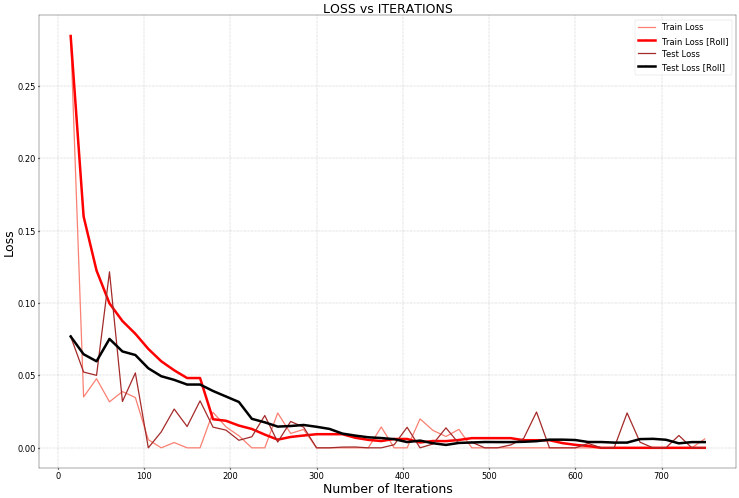

In [37]:
'''PLOTTTING THE LOSS GRAPH'''

plt.figure(figsize=[30,20], dpi=30)

plt.plot(iter_list, train_loss_list, '-', lw=3, c='salmon', label='Train Loss')
plt.plot(iter_list, train_roll_loss_list, '-|r', lw=6, label='Train Loss [Roll]')

plt.plot(iter_list, test_loss_list, '-', lw=3, c='brown', label='Test Loss')
plt.plot(iter_list, test_roll_loss_list, '-|k', lw=6, label='Test Loss [Roll]')

plt.title('LOSS vs ITERATIONS', size='30')
plt.xlabel('Number of Iterations', size='30')
plt.ylabel('Loss', size='30')

# plt.yticks(range(0.0,2.0,0.1), rotation='horizontal')
# plt.xticks(range(0,len(iter_list)+1,1), rotation='horizontal')


plt.grid(True, linestyle='-.')
plt.tick_params(labelcolor='k', labelsize='20', width=3)

plt.legend(fontsize='20')
fig1 = plt.gcf()
plt.show()

fig1.savefig('loss_vs_iterations[margin=1].png', dpi=75)

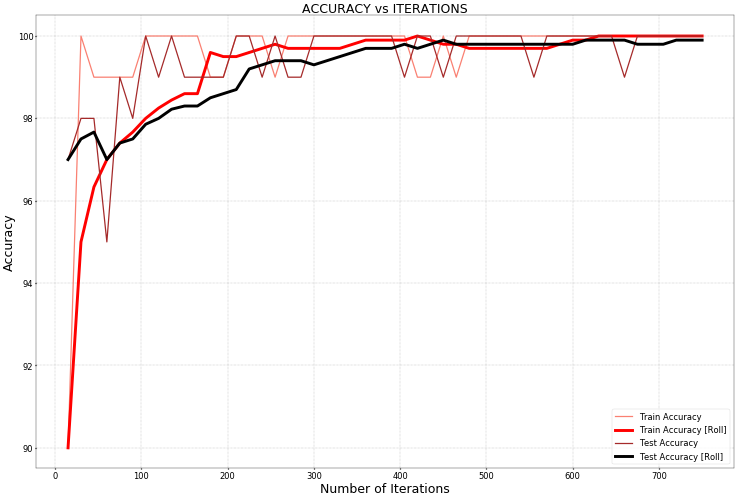

In [42]:
'''PLOTTTING THE ACCURACY GRAPH'''

plt.figure(figsize=[30,20], dpi=30)

plt.plot(iter_list, train_acc_list, '-', lw=3, c='salmon', label='Train Accuracy')
plt.plot(iter_list, train_roll_acc_list, '-|r', lw=7, label='Train Accuracy [Roll]')

plt.plot(iter_list, test_acc_list, '-', lw=3, c='brown', label='Test Accuracy')
plt.plot(iter_list, test_roll_acc_list, '-|k', lw=7, label='Test Accuracy [Roll]')

plt.title('ACCURACY vs ITERATIONS', size='30')
plt.xlabel('Number of Iterations', size='30')
plt.ylabel('Accuracy', size='30')


# plt.yticks(range(91,101,10), rotation='horizontal')
# plt.xticks(range(0,len(iter_list)+1,inspect_size), rotation='horizontal')

plt.grid(True, linestyle='-.')
plt.tick_params(labelcolor='k', labelsize='20', width=3)

plt.legend(fontsize='20')
fig1 = plt.gcf()
plt.show()

fig1.savefig('acc_vs_iterations[margin=1].png', dpi=75)

In [39]:
'''ANALYZING ACCURACY AND LOSS'''

### ACCURACY ANALYSIS
print('Accuracy Analysis : ')
print('====================')

# Getting maximum accuracy
test_max_acc = np.max(test_acc_list)
test_roll_max_acc = np.max(test_roll_acc_list)

print("[Average]")
print('--- Maximum accuracy on test-set  : {:.2f}'.format(test_roll_max_acc))
print('--- Iteration at maximum accuracy : {}'.format(iter_list[test_roll_acc_list.index(test_roll_max_acc)]))
print("[Absolute]")
print('--- Maximum accuracy on test-set  : {:.2f}'.format(test_max_acc))
print('--- Iteration at maximum accuracy : {}'.format(iter_list[test_acc_list.index(test_max_acc)]))

### LOSS ANALYSIS
print('\nLoss Analysis : ')
print('====================')

# Getting minimum loss
test_min_loss = np.min(test_loss_list)
test_roll_min_loss = np.min(test_roll_loss_list)

print("[Average]")
print('--- Minimum loss on test-set  : {:.2f}'.format(test_roll_min_loss))
print('--- Iteration at minimum loss : {}'.format(iter_list[test_roll_loss_list.index(test_roll_min_loss)]))
print("[Absolute]")
print('--- Minimum  loss on test-set  : {:.2f}'.format(test_min_loss))
print('--- Iteration at minimum loss : {}'.format(iter_list[test_loss_list.index(test_min_loss)]))


Accuracy Analysis : 
[Average]
--- Maximum accuracy on test-set  : 99.90
--- Iteration at maximum accuracy : 450
[Absolute]
--- Maximum accuracy on test-set  : 100.00
--- Iteration at maximum accuracy : 105

Loss Analysis : 
[Average]
--- Minimum loss on test-set  : 0.00
--- Iteration at minimum loss : 450
[Absolute]
--- Minimum  loss on test-set  : 0.00
--- Iteration at minimum loss : 105


# SAMPLE ANALYSIS

In [44]:
'''MODEL TESTS AND ANALYSIS'''

def process(matrix_path):

    """
    Processes an array of images.
    Takes their path as input and returns thier encoding.
    Helper function for `assess`.
    """
    
    matrix = get_image_from_path(matrix_path)
    matrix = cv2.resize(matrix, (global_image_width, global_image_height))
    matrix = np.rollaxis(matrix, 2, 0)
    matrix = matrix.reshape(1, 3, global_image_height, global_image_width)        
    matrix = torch.from_numpy(matrix)
    matrix_enc = get_encodings(matrix)

    return matrix_enc


def assess(anchor_path, image1_path, image2_path, threshold=triplet_loss_margin):
    
    """
    Takes in three image paths  : anchor - Image corresponding to data in database.
                                : image1 - First input image
                                : image2 - Second input image
    
    and prints which among image1 and image2 is close to anchor image.
    
    If difference is less than `threshold` then notifies accordingly.
    
    """
    
    anchor_enc = process(anchor_path)               
    image1_enc = process(image1_path)               
    image2_enc = process(image2_path)               

    image1_dist_list, image2_dist_list = return_diff(anchor_enc, image1_enc, image2_enc)
    image1_dist = image1_dist_list[0]
    image2_dist = image2_dist_list[0]
    
    diff = image1_dist - image2_dist
        
    # Return output
    
    print("=======================================================")   
    
    # Found forgery
    if(abs(diff) >= threshold):
        if(image1_dist < image2_dist):
            print("VERDICT : Second signature appears to forged.")
        else:
            print("VERDICT : First signature appears to forged.")
    
    # Cannot finnd forgery
    else:
        print("VERDICT : Unable to determine authenticity.")
        print("\tEither provide different samples or lower threshold.")
        print("\tAlso, please cross-check the Achor provided.")

    print("---> Current Threshold \t\t\t : {:.4f}".format(threshold))
    print("---> Difference between Encodings \t : {:.4f}".format(abs(diff)))        
    print("---> Distance between Anchor and Image_1 : {:.4f}".format(image1_dist))
    print("---> Distance between Anchor and Image_2 : {:.4f}".format(image2_dist))

    print("=======================================================")


In [45]:
# TESTS :
# Note : Format from dataset is [Anchor, Real, Fake]

threshold = triplet_loss_margin

# Test1 -- Signature2 fake.
index = test_master_index[0]
assess(index[0], index[1], index[2])

# Test1 -- Signature2 fake.
index = test_master_index[432]
assess(index[0], index[1], index[2])

# Test1 -- Signature1 fake.
index = test_master_index[100]
assess(index[0], index[2], index[1])

# Test1 -- Signature1 fake.
index = test_master_index[2313]
assess(index[1], index[2], index[0])

# Test1 -- Incorrect Anchor provided. Should complain.
index = test_master_index[15353]
assess(index[2], index[1], index[0])

VERDICT : Second signature appears to forged.
---> Current Threshold 			 : 1.0000
---> Difference between Encodings 	 : 4.5911
---> Distance between Anchor and Image_1 : 7.9553
---> Distance between Anchor and Image_2 : 12.5464
VERDICT : Second signature appears to forged.
---> Current Threshold 			 : 1.0000
---> Difference between Encodings 	 : 4.7556
---> Distance between Anchor and Image_1 : 7.2346
---> Distance between Anchor and Image_2 : 11.9902
VERDICT : First signature appears to forged.
---> Current Threshold 			 : 1.0000
---> Difference between Encodings 	 : 1.1851
---> Distance between Anchor and Image_1 : 9.4213
---> Distance between Anchor and Image_2 : 8.2362
VERDICT : First signature appears to forged.
---> Current Threshold 			 : 1.0000
---> Difference between Encodings 	 : 9.9845
---> Distance between Anchor and Image_1 : 15.7653
---> Distance between Anchor and Image_2 : 5.7808
VERDICT : Unable to determine authenticity.
	Either provide different samples or lower thre